# 📓 Prezicerea prețurilor locuințelor

---

## 📖 Introducere

În acest proiect vom aborda o problemă reală de regresie: **prezicerea prețurilor locuințelor**.

Vom folosi datele din competiția [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) de pe Kaggle.

**Obiectiv:**  
Antrenăm mai mulți algoritmi de regresie, optimizăm hiperparametrii lor și analizăm importanța caracteristicilor de intrare asupra predicțiilor.

---

## 🛣️ Planul de lucru

1. **Importul și explorarea datelor**
2. **Preprocesarea datelor** (curățare, selecție de coloane relevante)
3. **Split între setul de antrenament și testare**
4. **Antrenarea următorilor regresori:**
   - Linear Regression
   - K-Nearest Neighbors
   - Support Vector Machine
   - Decision Trees
   - Random Forest
   - XGBoost
   - CatBoost
   - Explainable Boosting Machine (EBM)
5. **Optimizarea hiperparametrilor** cu `GridSearchCV` și `BayesSearchCV`
6. **Evaluarea performanțelor** folosind:
   - Mean Squared Error (MSE)
   - Root Mean Squared Error (RMSE)
   - Mean Absolute Error (MAE)
7. **Explicabilitatea modelelor** cu SHAP, LIME și interpretabilitatea nativă pentru EBM
8. **Concluzii finale**



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Modele
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB

# Boosting
import xgboost as xgb
from catboost import CatBoostRegressor

# EBM
from interpret.glassbox import ExplainableBoostingRegressor

# Optimizare Bayesiana
from skopt import BayesSearchCV

# Explicabilitate
import shap
import lime
import lime.lime_tabular

# Warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")


C:\Users\anaho\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Încărcăm datele
df = pd.read_csv('datasets/train.csv')

# Afișăm primele 5 rânduri
df.head()


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:

df.info()       # vezi tipurile coloanelor și dacă sunt NaN
df.describe()   # vezi statistici despre coloanele numerice
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

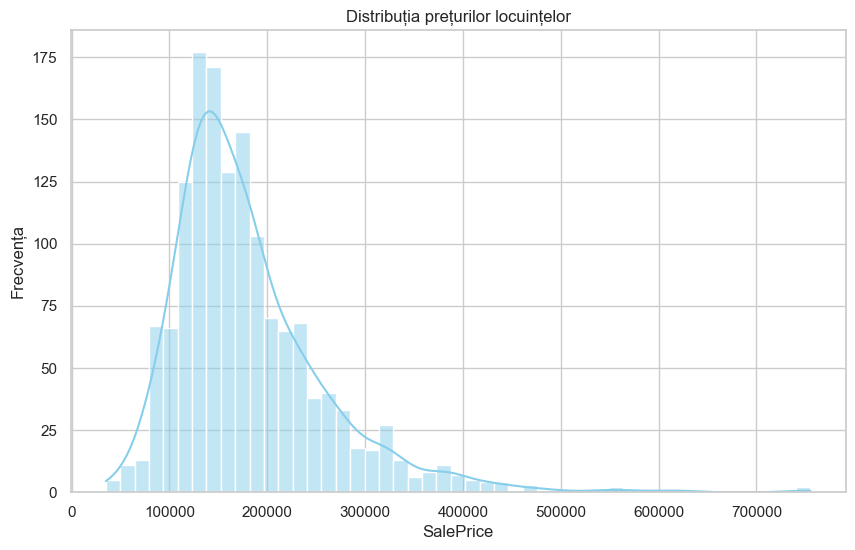

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, color="skyblue")
plt.title('Distribuția prețurilor locuințelor')
plt.xlabel('SalePrice')
plt.ylabel('Frecvența')
plt.show()


In [5]:
data = pd.read_csv("datasets/train.csv")

data = data.select_dtypes(include=[np.number]).dropna()  # Pastreaza doar numeric pentru simplitate initiala

X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Linear Regression

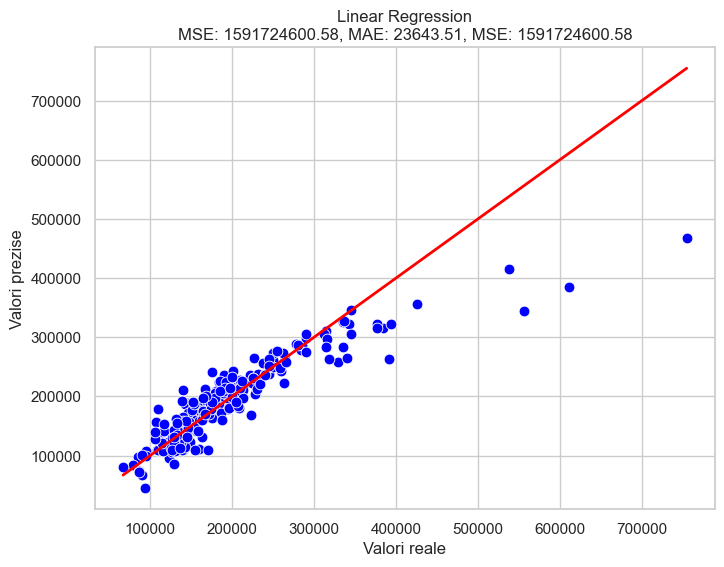

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Calculam metrice
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Grafic: Predictii vs Valori reale
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valori reale')
plt.ylabel('Valori prezise')
plt.title(f'Linear Regression\nMSE: {mse:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}')
plt.grid(True)
plt.show()


PermutationExplainer explainer: 226it [00:18, 12.40it/s]                         


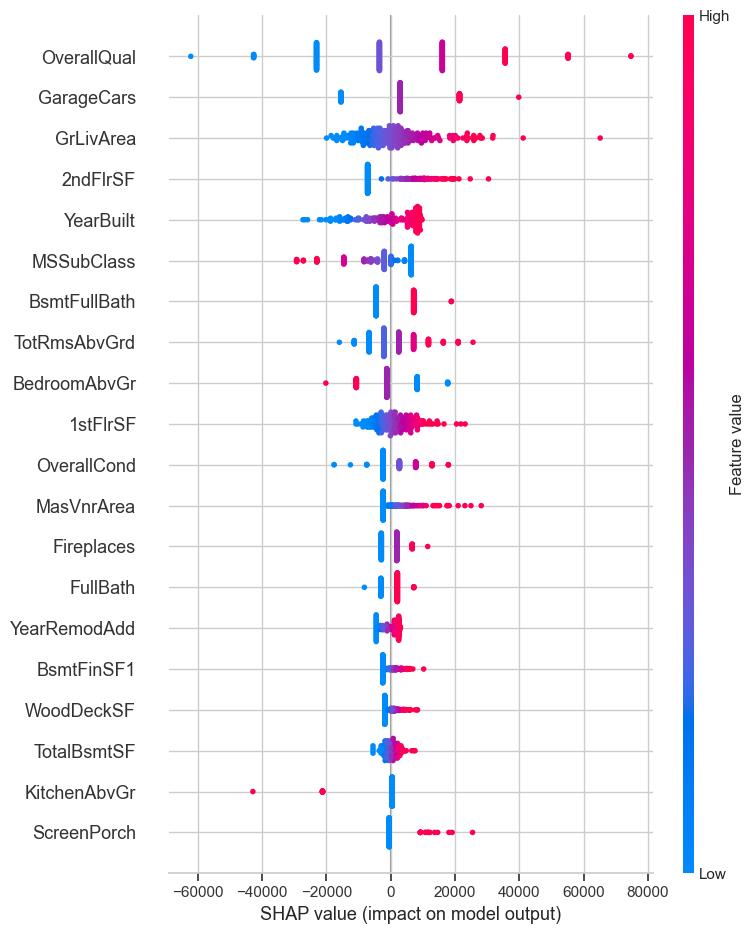

In [39]:
# SHAP
explainer = shap.Explainer(lr.predict, X_train)  # lr este modelul tau de LinearRegression
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# LIME 
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train, 
    feature_names=X.columns,
    mode='regression'
)

exp = explainer.explain_instance(X_test[0], lr.predict)
exp.show_in_notebook(show_table=True)


### K-Nearest Neighbors

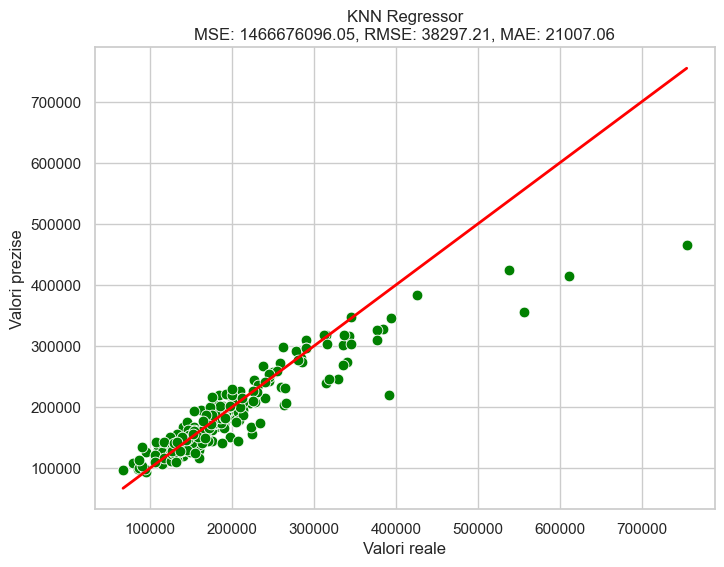

In [43]:

params_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn = KNeighborsRegressor(n_jobs=-1)
grid_knn = GridSearchCV(knn, params_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_knn, color='green', s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valori reale')
plt.ylabel('Valori prezise')
plt.title(f'KNN Regressor\nMSE: {mse_knn:.2f}, RMSE: {rmse_knn:.2f}, MAE: {mae_knn:.2f}')
plt.grid(True)
plt.show()


KNN BayesSearchCV - MSE: 1490988535.8653262, RMSE: 38613.32070497597, MAE: 21064.890536489256


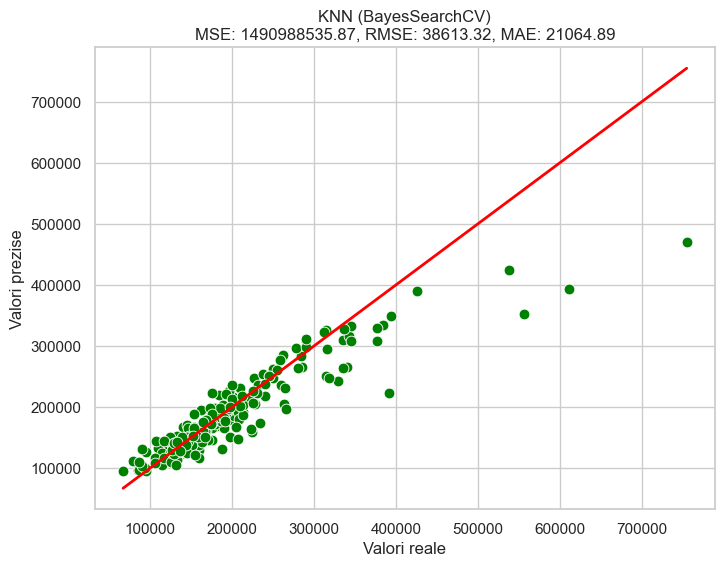

In [44]:
knn = KNeighborsRegressor(n_jobs=-1)

# Definim spatiul de cautare (BayesSearch poate folosi ranges)
search_spaces_knn = {
    'n_neighbors': (3, 15),         # Range de la 3 la 15
    'weights': ['uniform', 'distance'],
    'p': (1, 2)                     # 1 = distanta Manhattan, 2 = distanta Euclidiana
}

# BayesSearchCV
opt_knn = BayesSearchCV(
    estimator=knn,
    search_spaces=search_spaces_knn,
    n_iter=32,                        # Cate combinatii sa incerce
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

opt_knn.fit(X_train, y_train)

best_knn = opt_knn.best_estimator_

# Predictii
y_pred_knn = best_knn.predict(X_test)

# Metrice
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

# Afisam
print(f"KNN BayesSearchCV - MSE: {mse_knn}, RMSE: {rmse_knn}, MAE: {mae_knn}")

# Grafic
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_knn, color='green', s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valori reale')
plt.ylabel('Valori prezise')
plt.title(f'KNN (BayesSearchCV)\nMSE: {mse_knn:.2f}, RMSE: {rmse_knn:.2f}, MAE: {mae_knn:.2f}')
plt.grid(True)
plt.show()


Using 896 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 225/225 [01:37<00:00,  2.31it/s]


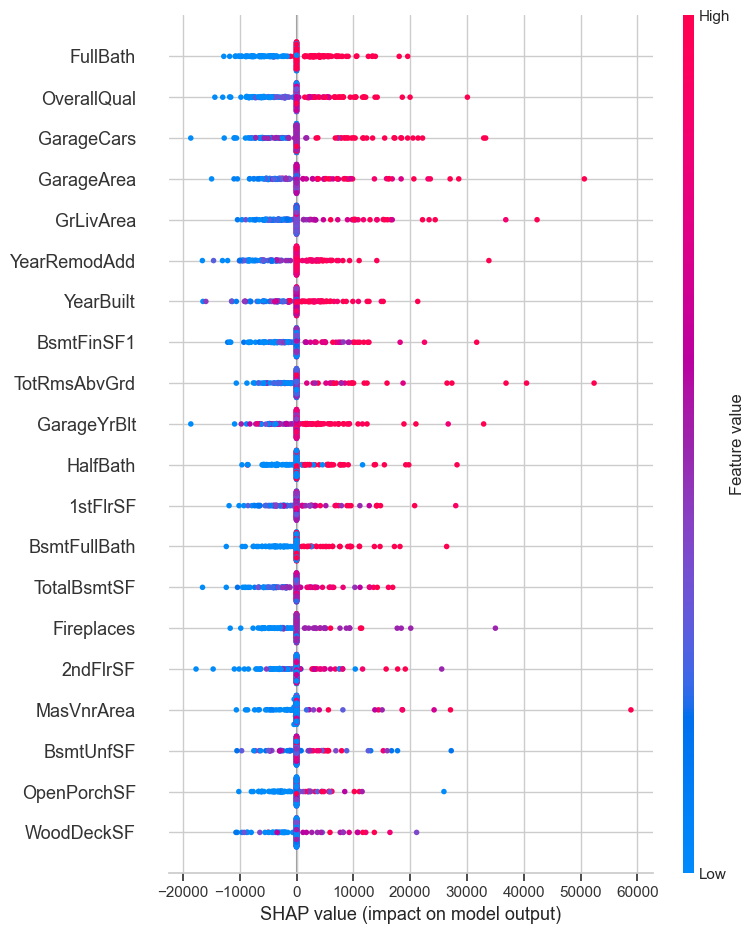

In [46]:
# SHAP 
explainer_shap_knn = shap.KernelExplainer(best_knn.predict, X_train, link="identity")
shap_values_knn = explainer_shap_knn.shap_values(X_test, nsamples=100)
shap.summary_plot(shap_values_knn, X_test, feature_names=X.columns)


# LIME

explainer_lime_knn = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    mode='regression'
)
exp_knn = explainer_lime_knn.explain_instance(X_test[0], best_knn.predict)
exp_knn.show_in_notebook(show_table=True)



### Support Vector Machine (SVR)

GridSearchCV SVR - MSE: 4174873244.7191505, RMSE: 64613.25904734376, MAE: 33938.183480614716
BayesSearchCV SVR - MSE: 4174879123.510023, RMSE: 64613.3045394679, MAE: 33938.2180646482


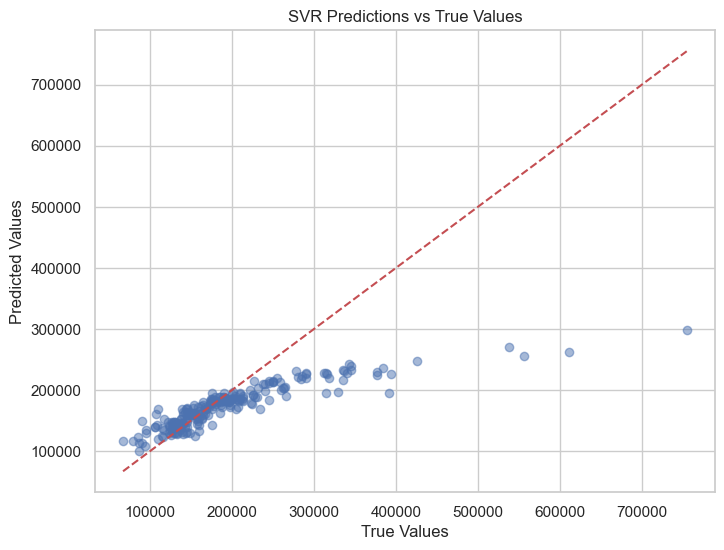

In [7]:
params_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf']
}

# 1. Optimizare GridSearchCV
svr = SVR()
grid_svr = GridSearchCV(svr, params_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train, y_train)

best_svr_grid = grid_svr.best_estimator_

# 2. Optimizare BayesSearchCV
params_bayes = {
    'C': (0.01, 10.0, 'log-uniform'),
    'epsilon': (0.01, 1.0, 'uniform'),
    'kernel': ['linear', 'rbf']
}

bayes_svr = BayesSearchCV(SVR(), search_spaces=params_bayes, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
bayes_svr.fit(X_train, y_train)

best_svr_bayes = bayes_svr.best_estimator_

# 3. Predicții pe test set pentru ambele modele
y_pred_svr_grid = best_svr_grid.predict(X_test)
y_pred_svr_bayes = best_svr_bayes.predict(X_test)

# 4. Calcul metrici
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

metrics_grid = regression_metrics(y_test, y_pred_svr_grid)
metrics_bayes = regression_metrics(y_test, y_pred_svr_bayes)

print(f"GridSearchCV SVR - MSE: {metrics_grid[0]}, RMSE: {metrics_grid[1]}, MAE: {metrics_grid[2]}")
print(f"BayesSearchCV SVR - MSE: {metrics_bayes[0]}, RMSE: {metrics_bayes[1]}, MAE: {metrics_bayes[2]}")



plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_svr_bayes, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('SVR Predictions vs True Values')
plt.show()



100%|██████████| 50/50 [02:39<00:00,  3.19s/it]


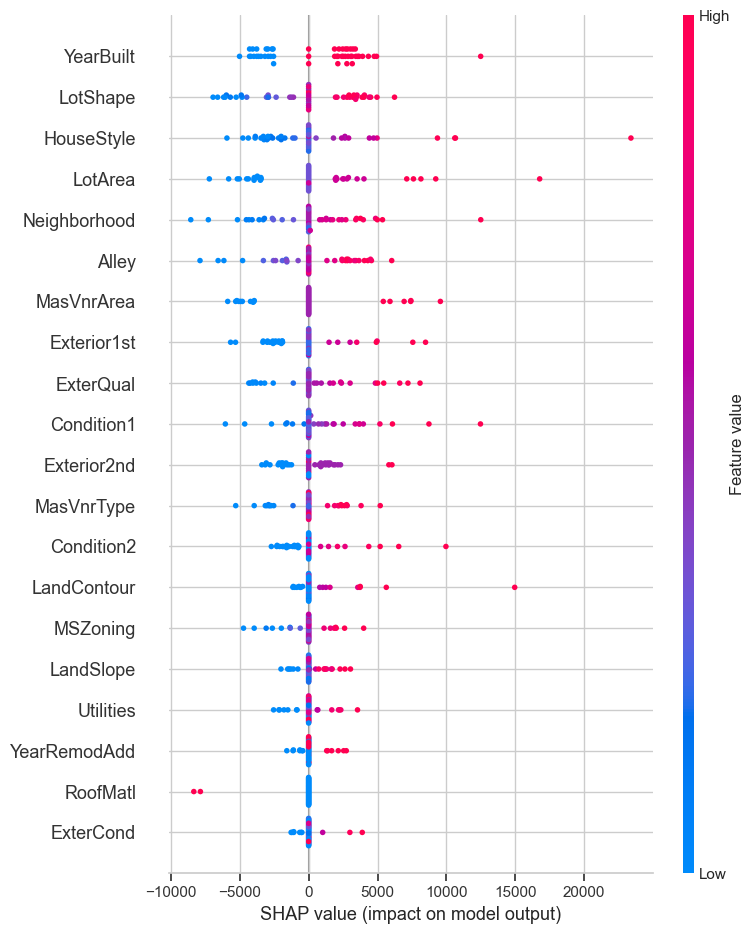

In [8]:

# SHAP
explainer = shap.KernelExplainer(best_svr_bayes.predict, X_train[:100])  # folosim subset mic ca să meargă repede
shap_values = explainer.shap_values(X_test[:50])  # explicăm doar 50 de instanțe

shap.summary_plot(shap_values, X_test[:50], feature_names=df.drop('SalePrice', axis=1).columns)

# LIME 
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=df.drop('SalePrice', axis=1).columns,
    mode='regression'
)

# Explicăm un exemplu random
i = 12
exp = explainer_lime.explain_instance(X_test[i], best_svr_bayes.predict, num_features=10)
exp.show_in_notebook(show_table=True)


### Decision Tree

GridSearchCV Decision Tree - MSE: 1543677049.7397928, RMSE: 39289.65576000626, MAE: 28112.12011762045
BayesSearchCV Decision Tree - MSE: 1804505397.380987, RMSE: 42479.47030485416, MAE: 27193.38870864763


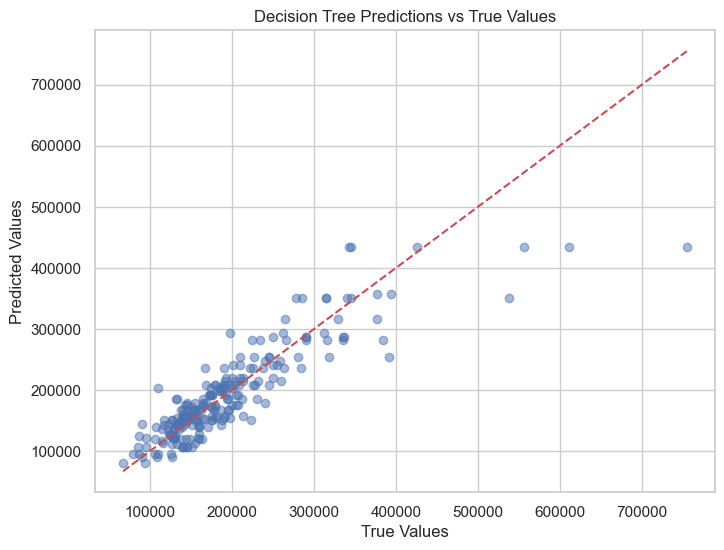

In [9]:
params_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 1. Optimizare cu GridSearchCV
dt = DecisionTreeRegressor(random_state=42)
grid_dt = GridSearchCV(dt, params_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(X_train, y_train)

best_dt_grid = grid_dt.best_estimator_

# 2. Optimizare cu BayesSearchCV
params_bayes_dt = {
    'max_depth': (3, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20)
}

bayes_dt = BayesSearchCV(
    DecisionTreeRegressor(random_state=42),
    search_spaces=params_bayes_dt,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
bayes_dt.fit(X_train, y_train)

best_dt_bayes = bayes_dt.best_estimator_

# 3. Predictii
y_pred_dt_grid = best_dt_grid.predict(X_test)
y_pred_dt_bayes = best_dt_bayes.predict(X_test)

# 4. Metrici
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

metrics_dt_grid = regression_metrics(y_test, y_pred_dt_grid)
metrics_dt_bayes = regression_metrics(y_test, y_pred_dt_bayes)

print(f"GridSearchCV Decision Tree - MSE: {metrics_dt_grid[0]}, RMSE: {metrics_dt_grid[1]}, MAE: {metrics_dt_grid[2]}")
print(f"BayesSearchCV Decision Tree - MSE: {metrics_dt_bayes[0]}, RMSE: {metrics_dt_bayes[1]}, MAE: {metrics_dt_bayes[2]}")


plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_dt_bayes, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Predictions vs True Values')
plt.show()


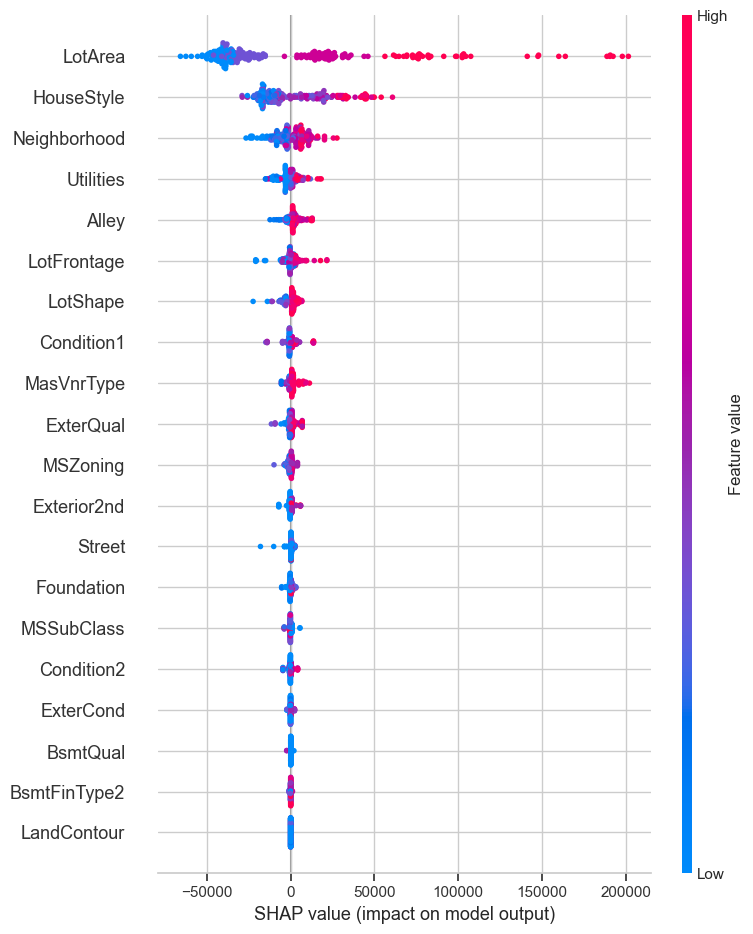

In [10]:
#SHAP
explainer_dt = shap.TreeExplainer(best_dt_bayes)
shap_values_dt = explainer_dt.shap_values(X_test)

shap.summary_plot(shap_values_dt, X_test, feature_names=df.drop('SalePrice', axis=1).columns)

# LIME
explainer_lime_dt = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=df.drop('SalePrice', axis=1).columns,
    mode='regression'
)

i = 10
exp_dt = explainer_lime_dt.explain_instance(X_test[i], best_dt_bayes.predict, num_features=10)
exp_dt.show_in_notebook(show_table=True)



### Random Forest

GridSearchCV Random Forest - MSE: 996306489.3102785, RMSE: 31564.323045335197, MAE: 19573.961822222223
BayesSearchCV Random Forest - MSE: 997741000.1684879, RMSE: 31587.038483664273, MAE: 19573.98951111111


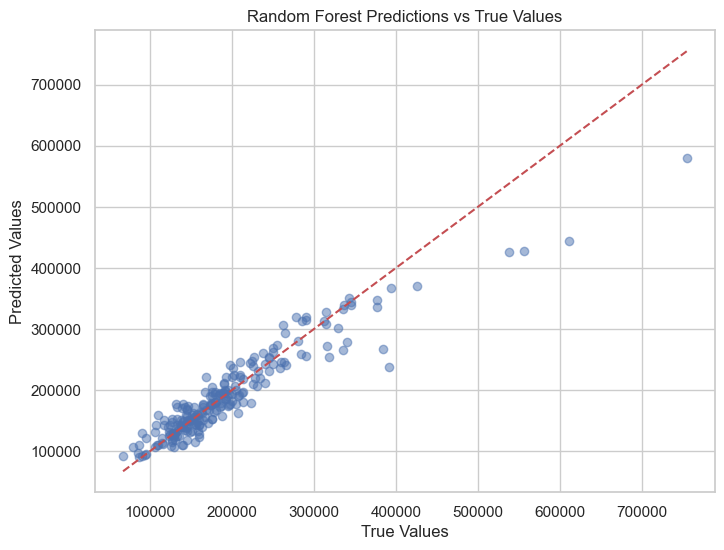

In [11]:
params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Optimizare cu GridSearchCV
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_rf = GridSearchCV(rf, params_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf_grid = grid_rf.best_estimator_

# 2. Optimizare cu BayesSearchCV
params_bayes_rf = {
    'n_estimators': (100, 500),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5)
}

bayes_rf = BayesSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    search_spaces=params_bayes_rf,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
bayes_rf.fit(X_train, y_train)

best_rf_bayes = bayes_rf.best_estimator_

# 3. Predictii
y_pred_rf_grid = best_rf_grid.predict(X_test)
y_pred_rf_bayes = best_rf_bayes.predict(X_test)

# 4. Metrici
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

metrics_rf_grid = regression_metrics(y_test, y_pred_rf_grid)
metrics_rf_bayes = regression_metrics(y_test, y_pred_rf_bayes)

print(f"GridSearchCV Random Forest - MSE: {metrics_rf_grid[0]}, RMSE: {metrics_rf_grid[1]}, MAE: {metrics_rf_grid[2]}")
print(f"BayesSearchCV Random Forest - MSE: {metrics_rf_bayes[0]}, RMSE: {metrics_rf_bayes[1]}, MAE: {metrics_rf_bayes[2]}")


plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf_bayes, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Predictions vs True Values')
plt.show()



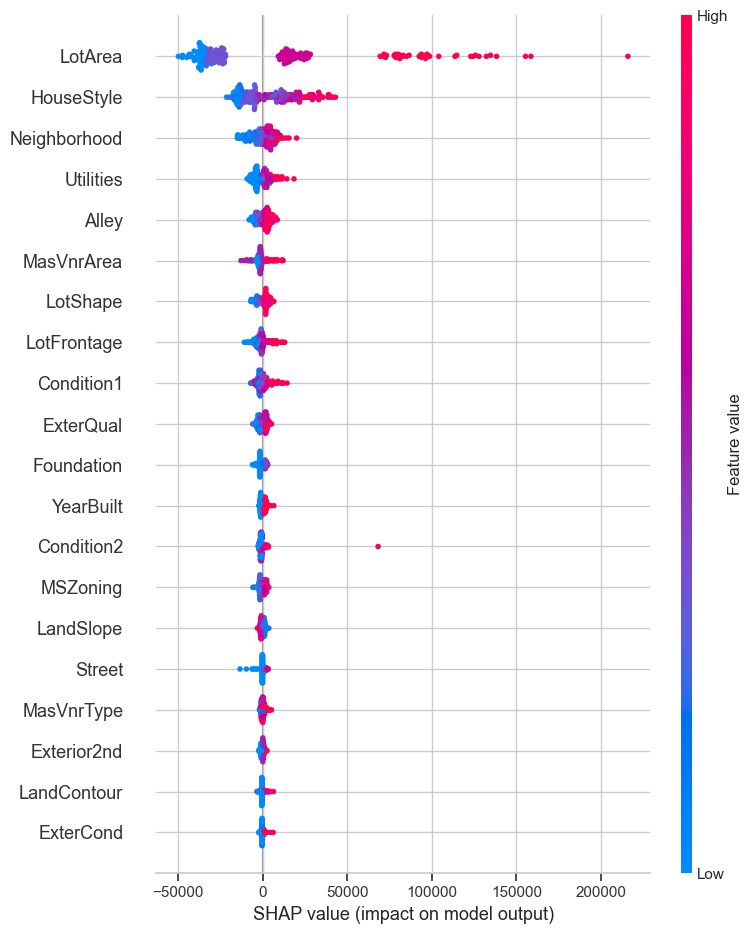

In [12]:
#SHAP

explainer_rf = shap.TreeExplainer(best_rf_bayes)
shap_values_rf = explainer_rf.shap_values(X_test)

shap.summary_plot(shap_values_rf, X_test, feature_names=df.drop('SalePrice', axis=1).columns)


#LIME

explainer_lime_rf = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=df.drop('SalePrice', axis=1).columns,
    mode='regression'
)

i = 8
exp_rf = explainer_lime_rf.explain_instance(X_test[i], best_rf_bayes.predict, num_features=10)
exp_rf.show_in_notebook(show_table=True)



### Xtreme Gradient Boost